# Loading data

In [1]:
!pip install langdetect emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 41.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=40c0587063e9ebda4b003d95e00c0da931641ca0f3e77710a4975accc1e06047
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import emoji

from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
file_path = "/content/app_store_music_reviews.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=["review", "rating", "date"])
df["date"] = pd.to_datetime(df["date"])
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]
df.head()

,app,country,title,review,rating,date
0,Spotify,MX,Muy buena aplicación de música. Casi sin anunc...,La,5,2025-05-21 18:57:56-07:00
1,SoundCloud,US,I have loved you from day 1 bi,"Nah fr tho, omm nothing but love for SoundClou...",5,2025-05-21 18:56:41-07:00
2,Spotify,MX,Los amo,Los amo,5,2025-05-21 18:56:12-07:00
3,Deezer,US,Must have a premium account to download music,I got this music app so I could download songs...,1,2025-05-21 18:50:34-07:00
4,Apple Music,US,4 star,I tunes don’t have all the songs like to liste...,4,2025-05-21 18:50:04-07:00


# Language Detection
We use `langdetect` to estimate the primary language of each review. This helps uncover how multilingual feedback varies across countries, and whether sentiment is influenced by regional expression styles.

In [4]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

sample = df.sample(1000, random_state=1)  # quick test
sample["lang"] = sample["review"].apply(detect_language)
sample["lang"].value_counts().head(10)

,count
lang,
en,398
es,91
fr,58
pt,44
ja,44
de,41
it,40
ru,34
ko,34


This lets us estimate how many non-English reviews are in each country's feed — a valuable insight for global UX.

# Sentiment Scoring
VADER is a lexicon-based sentiment analysis tool optimized for short, informal text like user reviews. It returns a "compound" score from -1 to 1: we’ll use this to classify reviews as broadly positive or negative.

In [5]:
sia = SentimentIntensityAnalyzer()
df["sentiment"] = df["review"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,app,country,title,review,rating,date,sentiment
0,Spotify,MX,Muy buena aplicación de música. Casi sin anunc...,La,5,2025-05-21 18:57:56-07:00,0.0000
1,SoundCloud,US,I have loved you from day 1 bi,"Nah fr tho, omm nothing but love for SoundClou...",5,2025-05-21 18:56:41-07:00,-0.6958
2,Spotify,MX,Los amo,Los amo,5,2025-05-21 18:56:12-07:00,0.0000
3,Deezer,US,Must have a premium account to download music,I got this music app so I could download songs...,1,2025-05-21 18:50:34-07:00,-0.5647
4,Apple Music,US,4 star,I tunes don’t have all the songs like to liste...,4,2025-05-21 18:50:04-07:00,0.1901


# Sentiment by Country

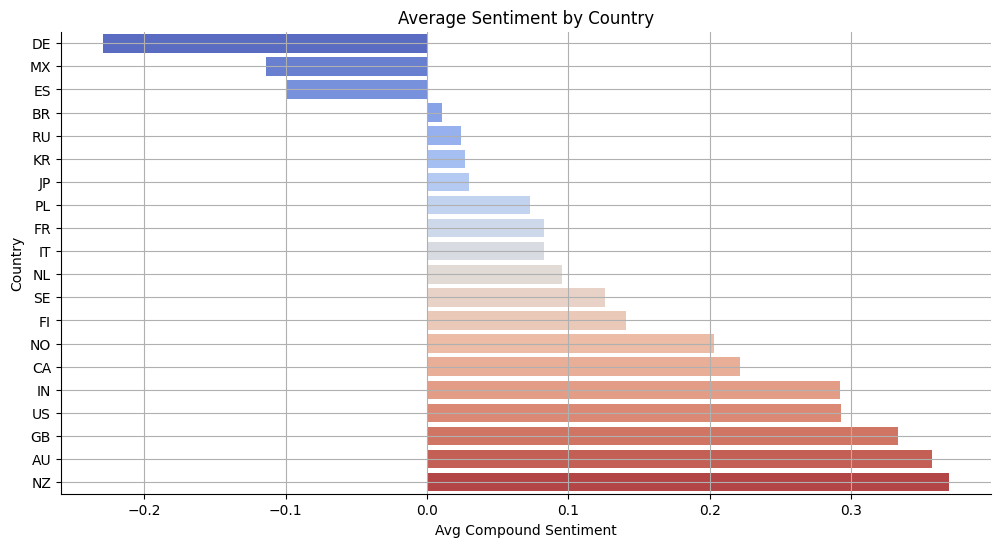

In [6]:
country_sentiment = df.groupby("country")["sentiment"].mean().reset_index()
country_sentiment = country_sentiment.sort_values(by="sentiment")

plt.figure(figsize=(12, 6))
sns.barplot(data=country_sentiment, x="sentiment", y="country", palette="coolwarm")
plt.title("Average Sentiment by Country")
plt.xlabel("Avg Compound Sentiment")
plt.ylabel("Country")
sns.despine()
plt.grid(True)
plt.show()

Some regions are consistently more critical or enthusiastic — reflecting expectations, pricing, and local competition.

# Review Length vs. Rating

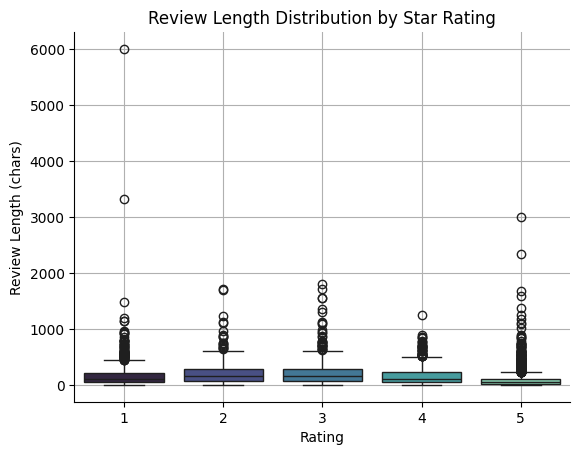

In [7]:
df["length"] = df["review"].apply(len)
sns.boxplot(data=df, x="rating", y="length", palette="mako")
plt.title("Review Length Distribution by Star Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length (chars)")
plt.grid(True)
sns.despine()
plt.show()

Longer reviews tend to accompany both praise and complaints — showing higher engagement from both ends of the satisfaction spectrum.

# Top Positive vs. Negative Keywords
To understand the language used in very positive and very negative reviews, we filter based on sentiment thresholds: compound score > 0.6 for positive, < -0.4 for negative. We then use `CountVectorizer` to find the most common terms used in each class.

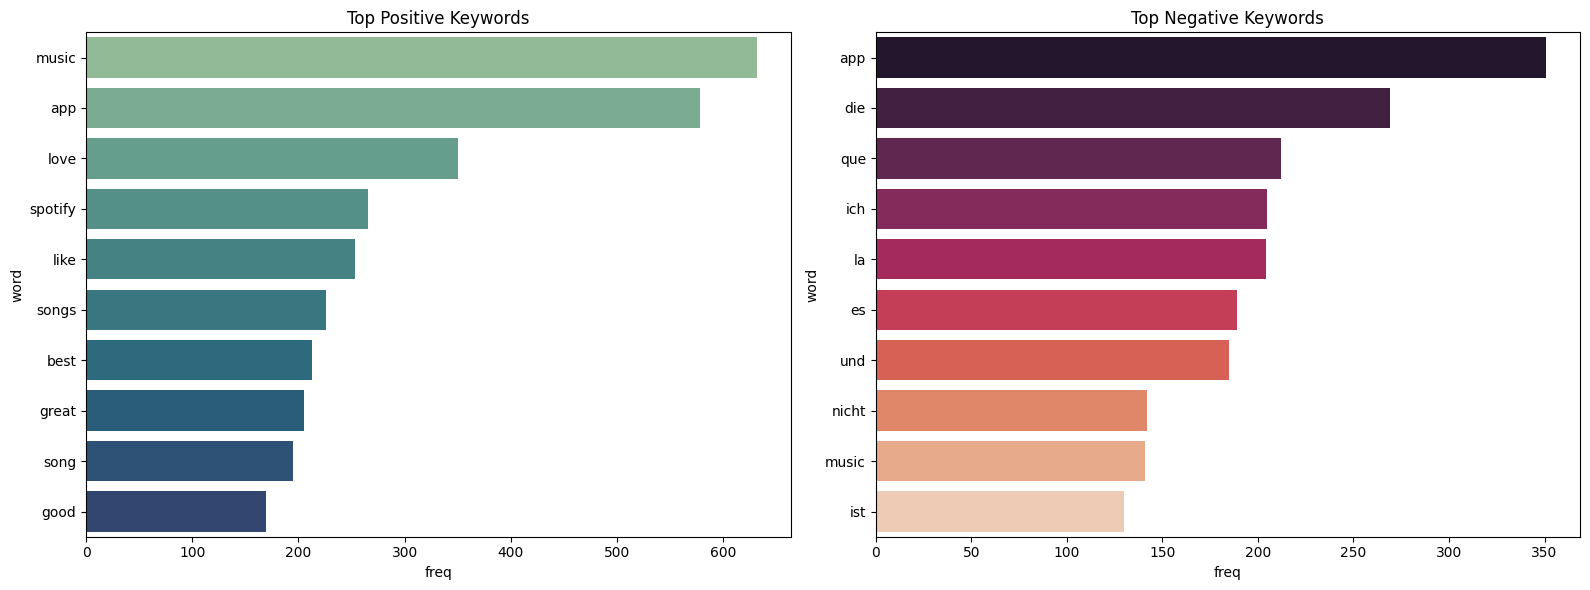

In [8]:
positive = df[df["sentiment"] > 0.6]["review"]
negative = df[df["sentiment"] < -0.4]["review"]

vectorizer = CountVectorizer(stop_words="english", max_features=50)
pos_counts = np.sum(vectorizer.fit_transform(positive).toarray(), axis=0)
pos_words = vectorizer.get_feature_names_out()
pos_freq = pd.DataFrame({"word": pos_words, "freq": pos_counts}).sort_values("freq", ascending=False)

vectorizer = CountVectorizer(stop_words="english", max_features=50)
neg_counts = np.sum(vectorizer.fit_transform(negative).toarray(), axis=0)
neg_words = vectorizer.get_feature_names_out()
neg_freq = pd.DataFrame({"word": neg_words, "freq": neg_counts}).sort_values("freq", ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=pos_freq.head(10), x="freq", y="word", ax=axs[0], palette="crest")
axs[0].set_title("Top Positive Keywords")
sns.barplot(data=neg_freq.head(10), x="freq", y="word", ax=axs[1], palette="rocket")
axs[1].set_title("Top Negative Keywords")
plt.tight_layout()
plt.show()

# Emoji Usage Heatmap
Emojis are emotionally expressive elements often overlooked in review mining. We extract and count emoji characters from all reviews to reveal which emotions dominate user feedback in visual form.

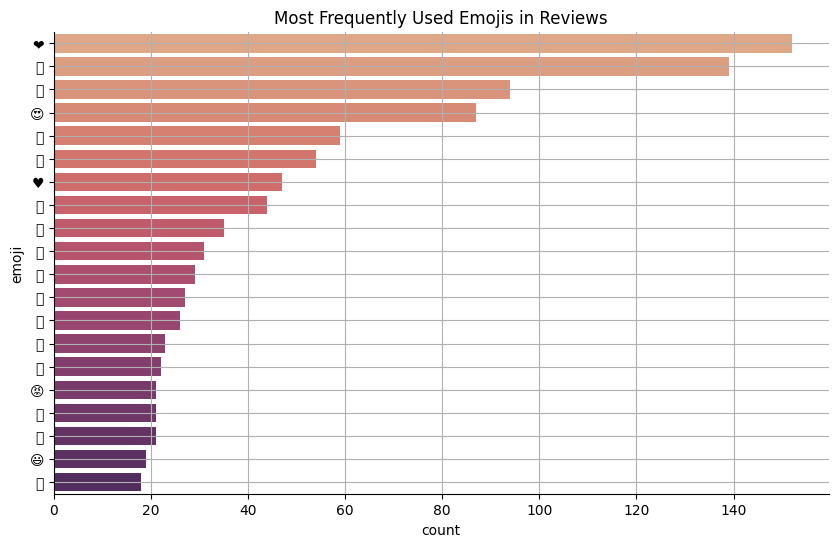

In [9]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

df["emojis"] = df["review"].apply(extract_emojis)
all_emojis = ''.join(df["emojis"].dropna().values)
emoji_counts = Counter(all_emojis)
emoji_df = pd.DataFrame(emoji_counts.items(), columns=["emoji", "count"])
emoji_df = emoji_df.sort_values("count", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=emoji_df, x="count", y="emoji", palette="flare")
plt.title("Most Frequently Used Emojis in Reviews")
sns.despine()
plt.grid(True)
plt.show()